In [ ]:
"""
burgers_equation.ipynb

Created on Sun Feb 26 2023

@authors: Luca d'Amico-Wong, Lukas Fesser, and Richard Qiu

This file contains code to reproduce and extend the results on the 1D Burgers equation presented in 
"DPM - A Novel Training Method for Physics-Informed Neural Networks in Extrapolation" (2021)
"""

'\nburgers_equation.ipynb\n\nCreated on Sun Feb 26 2023\n\n@authors: Luca d\'Amico-Wong, Lukas Fesser, and Richard Qiu\n\nThis file contains code to reproduce and extend the results on the 1D Burgers equation presented in \n"DPM - A Novel Training Method for Physics-Informed Neural Networks in Extrapolation" (2021)\n'

For a given field $u(x, t)$, the viscous Burger's equation is given by $$\frac{\delta u}{\delta t} + u\frac{\delta u}{\delta x} = \nu \frac{\delta^2 u}{\delta x^2}$$
Here, we consider $x \in [-1, 1]$ and $t \in [0, 0.5]$. We use the Dirichley boundary conditions and initial conditions
$$ u(-1, t) = u(1, t) = 0 \text{ , } u(x, 0) = -\sin(\pi x)$$
We train an MLP with tanh activation with the Burger's equation as part of the loss function and compare its accuracy in an intrapolation and extrapolation setting.

## Preliminaries

In [ ]:
# install deepxde

%pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import packages

import deepxde as dde

import numpy as np

import torch

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

torch.cuda.is_available()
device = torch.device("cuda")

In [ ]:
import pandas as pd
import seaborn as sns
import pickle

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.0)

## Defining Burger's Equation

In [ ]:
# define the PDE
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

In [ ]:
# define a computational geometry and a time domain
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.5)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [ ]:
# define the boundary and initial conditions
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

In [ ]:
# define the time PDE problem
data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                        num_domain=25400, num_boundary=80, num_initial=160)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/229 Project'


# import data for the true solution
def gen_testdata():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/229 Project


## Further Experiments

### Helper Functions

In [ ]:
def get_errors(model, X, y_true):
  # compare the true solution with the predicted solution
  y_pred = model.predict(X)
  f = model.predict(X, operator=pde)
  print("Mean residual:", np.mean(np.absolute(f)))
  print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))

In [ ]:
# compute the L2 relative error between the true solution and the predicted solution
def plot_l2_errors(model, X, y_true, label=None, ax = None, title="Title"):

  rel_l2_errors = []

  for i in range(0, 25600, 256):
      cur_y_pred = model.predict(X[i:i+256])
      cur_y_sol = y_true[i:i+256]

      # collect the relative L2 errors in a list
      rel_l2_errors.append(dde.metrics.l2_relative_error(cur_y_sol, cur_y_pred))

  # plot the relative L2 errors
  x = np.linspace(0, 0.01 * 100, 100)
  sns.lineplot(x=x, y=rel_l2_errors, label=label, ax=ax)
  sns.despine()

  if ax:
    ax.set_xlabel("t")
    ax.set_ylabel("L2 relative error")
    ax.set_title(title)

  else:
    plt.xlabel("t")
    plt.ylabel("L2 relative error")
    # plt.show()

  return rel_l2_errors

In [ ]:
# plot heatmap of solution over time
def plot_heatmap(X, y=None, model=None, title="Title", ax=None):

  if model:
    y = model.predict(X)

  data_dict = {"x": [x for (x, _) in X], "t": [t for (_, t) in X], "value": y[:,0]}
  ref_sol = pd.DataFrame(data = data_dict)
  ref_sol = ref_sol.round(3)
  ref_sol = ref_sol.pivot("x", "t", "value")
  sns.heatmap(ref_sol, yticklabels=64, xticklabels=10, ax = ax)

  if ax:
    ax.set_title(title)

  else:
    plt.title(title)
    # plt.show()

In [ ]:
def get_burger_data(end_time=0.5):

  # define a computational geometry and a time domain
  geom = dde.geometry.Interval(-1, 1)
  timedomain = dde.geometry.TimeDomain(0, end_time)
  geomtime = dde.geometry.GeometryXTime(geom, timedomain)

  # define the boundary and initial conditions
  bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
  ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

  # define the time PDE problem
  data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                          num_domain=25400, num_boundary=80, num_initial=160)
  
  return data

### Examining Training Dynamics

In [ ]:
# choose the network architecture and the training method
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)
models = [model]

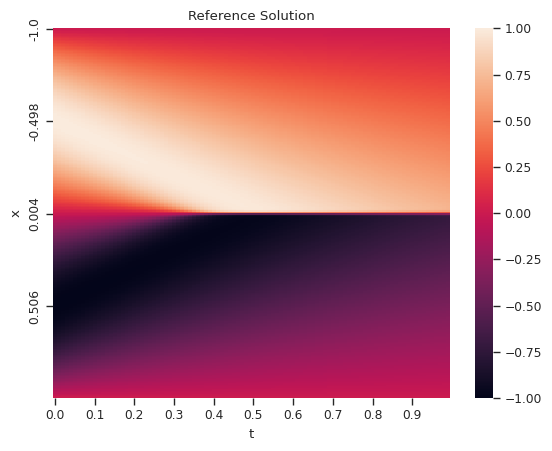

In [ ]:
plot_heatmap(X, y=y_true, title="Reference Solution")

Compiling model...
Building feed-forward neural network...
'build' took 0.063239 s



/usr/local/lib/python3.9/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.638170 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.96e-01, 3.23e-02, 5.74e-01]    [2.96e-01, 3.23e-02, 5.74e-01]    []  
2500      [5.72e-03, 2.61e-04, 1.81e-02]    [5.72e-03, 2.61e-04, 1.81e-02]    []  

Best model at step 2500:
  train loss: 2.41e-02
  test loss: 2.41e-02
  test metric: []

'train' took 20.971625 s

Training model...

Step      Train loss                        Test loss                         Test metric
2500      [5.72e-03, 2.61e-04, 1.81e-02]    [5.72e-03, 2.61e-04, 1.81e-02]    []  
5000      [3.09e-03, 5.01e-05, 1.19e-02]    [3.09e-03, 5.01e-05, 1.19e-02]    []  

Best model at step 5000:
  train loss: 1.50e-02
  test loss: 1.50e-02
  test metric: []

'train' took 20.973266 s

Training model...

Step      Train loss                        Test loss                         Test metric
5000      [3.09e-03, 5.01e-05, 1.19e-02]    [3.09e-03, 5

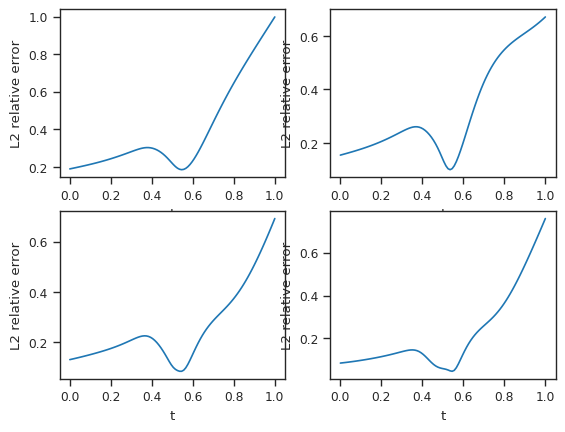

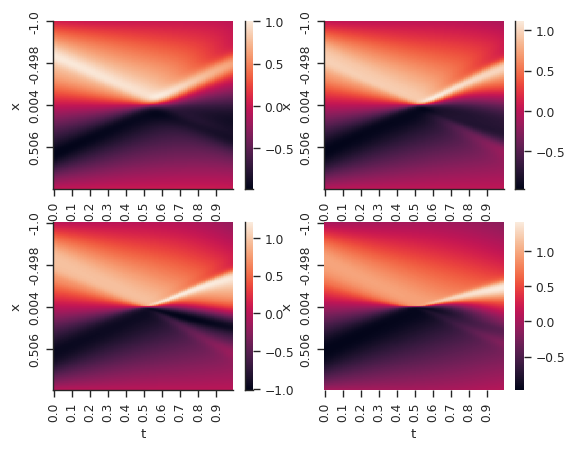

In [ ]:
X, y_true = gen_testdata()

for model in models:
  model.compile("adam", lr=1e-3, loss_weights=[1, 1, 1])

  fig,ax = plt.subplots(2,2)
  ax = ax.flatten()

  fig1,ax1 = plt.subplots(2,2)
  ax1 = ax1.flatten()

  for i in range(4):
    model.train(iterations=2500, display_every=np.inf)
    plot_l2_errors(model, X, y_true, ax=ax[i], title=None)
    plot_heatmap(X, model=model, title=None, ax=ax1[i])

### Increasing Training Domain

Compiling model...
Building feed-forward neural network...
'build' took 0.052223 s

'compile' took 4.584040 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.72e-02, 4.87e-02, 3.68e-01]    [1.72e-02, 4.87e-02, 3.68e-01]    []  
10000     [5.31e-04, 1.25e-06, 2.62e-04]    [5.31e-04, 1.25e-06, 2.62e-04]    []  

Best model at step 10000:
  train loss: 7.94e-04
  test loss: 7.94e-04
  test metric: []

'train' took 47.277544 s

Compiling model...
Building feed-forward neural network...
'build' took 0.080162 s



/usr/local/lib/python3.9/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.533328 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.98e-02, 3.76e-03, 5.41e-01]    [1.98e-02, 3.76e-03, 5.41e-01]    []  
10000     [6.58e-04, 7.08e-07, 4.52e-04]    [6.58e-04, 7.08e-07, 4.52e-04]    []  

Best model at step 10000:
  train loss: 1.11e-03
  test loss: 1.11e-03
  test metric: []

'train' took 49.097679 s

Compiling model...
Building feed-forward neural network...
'build' took 0.085336 s



/usr/local/lib/python3.9/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.528319 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.07e-02, 1.86e-02, 5.80e-01]    [5.07e-02, 1.86e-02, 5.80e-01]    []  
10000     [2.06e-03, 4.80e-06, 7.05e-04]    [2.06e-03, 4.80e-06, 7.05e-04]    []  

Best model at step 10000:
  train loss: 2.77e-03
  test loss: 2.77e-03
  test metric: []

'train' took 46.723293 s

Compiling model...
Building feed-forward neural network...
'build' took 0.058302 s



/usr/local/lib/python3.9/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.846048 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.31e-01, 2.55e-02, 5.03e-01]    [1.31e-01, 2.55e-02, 5.03e-01]    []  
10000     [1.37e-03, 5.41e-06, 1.10e-03]    [1.37e-03, 5.41e-06, 1.10e-03]    []  

Best model at step 10000:
  train loss: 2.48e-03
  test loss: 2.48e-03
  test metric: []

'train' took 48.398497 s

Compiling model...
Building feed-forward neural network...
'build' took 0.054861 s



/usr/local/lib/python3.9/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.785836 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.28e-03, 5.09e-03, 4.63e-01]    [3.28e-03, 5.09e-03, 4.63e-01]    []  
10000     [1.20e-03, 1.76e-06, 9.77e-04]    [1.20e-03, 1.76e-06, 9.77e-04]    []  

Best model at step 10000:
  train loss: 2.18e-03
  test loss: 2.18e-03
  test metric: []

'train' took 47.468166 s

Compiling model...
Building feed-forward neural network...
'build' took 0.054491 s



/usr/local/lib/python3.9/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.820888 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.11e-01, 8.00e-01, 1.76e-01]    [4.11e-01, 8.00e-01, 1.76e-01]    []  
10000     [1.53e-03, 5.50e-06, 1.41e-03]    [1.53e-03, 5.50e-06, 1.41e-03]    []  

Best model at step 10000:
  train loss: 2.95e-03
  test loss: 2.95e-03
  test metric: []

'train' took 47.774878 s



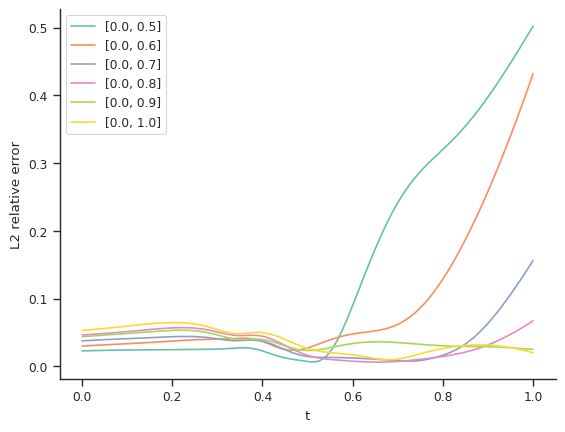

In [ ]:
X, y_true = gen_testdata()

for end_time in np.linspace(0.5, 1.0, 6):

  net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
  data = get_burger_data(end_time)
  model = dde.Model(data, net)
  model.compile("adam", lr=1e-3, loss_weights=[1, 1, 1])
  model.train(iterations=10000, display_every=np.inf)

  errors = plot_l2_errors(model, X, y_true, label=f"[0.0, {end_time}]")


# Assign the colors to the lines after plotting
palette = sns.color_palette("Set2")
lines = plt.gca().lines
for i in range(len(lines)):
    lines[i].set_color(palette[i])

# Get the handles (lines) and labels for the legend
handles, labels = plt.gca().get_legend_handles_labels()

# Create a new legend with the correct colors
plt.legend(handles, labels, loc='best')

plt.show()

Compiling model...
Building feed-forward neural network...
'build' took 0.058976 s



/usr/local/lib/python3.9/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.891334 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.06e-02, 7.52e-02, 7.28e-01]    [2.06e-02, 7.52e-02, 7.28e-01]    []  
10000     [1.81e-03, 1.04e-05, 1.76e-03]    [1.81e-03, 1.04e-05, 1.76e-03]    []  

Best model at step 10000:
  train loss: 3.58e-03
  test loss: 3.58e-03
  test metric: []

'train' took 49.205355 s

Compiling model...
Building feed-forward neural network...
'build' took 0.057062 s

'compile' took 1.893972 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.11e-02, 3.20e-02, 3.89e-01]    [1.11e-02, 3.20e-02, 3.89e-01]    []  
10000     [1.11e-03, 2.64e-06, 8.68e-04]    [1.11e-03, 2.64e-06, 8.68e-04]    []  

Best model at step 10000:
  train loss: 1.98e-03
  test loss: 1.98e-03
  test metric: []

'train' took 48.344040 s

Compiling model...
Buildin

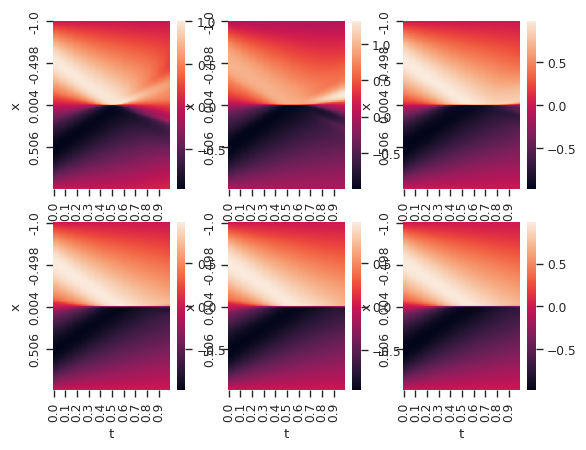

In [ ]:
X, y_true = gen_testdata()

fig1,ax1 = plt.subplots(2,3)
ax1 = ax1.flatten()

for i, end_time in enumerate(np.linspace(0.5, 1.0, 6)):

  net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
  data = get_burger_data(end_time)
  model = dde.Model(data, net)
  model.compile("adam", lr=1e-3, loss_weights=[1, 1, 1])
  model.train(iterations=10000, display_every=np.inf)

  plot_heatmap(X, model=model, title=None, ax=ax1[i])